#Loan default prediction

---



**Author: Magdalena Sztuk**

The puropuse of this notebook is to choose the best model in default prediction problem. The notebook was devided into four parts:


1.   Data exploration
2.   Pre-processing
3.   Models creation
4.   Model selection

Data source: https://www.kaggle.com/wendykan/lending-club-loan-data

Due to the hardware limitations, we decided to use Google Colab to speed up model computing.


In [ ]:
#Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from google.colab import files
import io
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import  metrics

#Google collab libraries
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


##1. Data exploration




a) datasets import

In [ ]:
# Google collab settings
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
#Import data from Google Drive - dictionary dataset
link= 'https://drive.google.com/open?id=1POSrghboFvkGvt_Z5TJ0qFyRdHX2b1Lo'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('LCADictionary.xlxs')  
dictionary = pd.read_excel('LCADictionary.xlxs')
dictionary.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...


In [ ]:
#Import data from Google Drive - loan dataset
link= 'https://drive.google.com/open?id=1rxMAhSUV8nqm8gnpKDfjbrVBJTNF9NWC'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('loan_data.csv')  
loan = pd.read_csv('loan_data.csv')
loan.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,...,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,...,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0.0,Apr-2011,0.0,NaN,NaN,8.0,0.0,4599,19.1,13.0,w,4787.21,4787.21,353.89,353.89,...,0.0,0.0,136927.0,11749.0,13800.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,MORTGAGE,92000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,985xx,WA,16.74,0.0,Feb-2006,0.0,NaN,NaN,10.0,0.0,5468,78.1,13.0,w,3831.93,3831.93,286.71,286.71,...,0.0,0.0,385183.0,36151.0,5000.0,44984.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,MORTGAGE,57250.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,212xx,MD,26.35,0.0,Dec-2000,0.0,NaN,NaN,12.0,0.0,829,3.6,26.0,w,29339.02,29339.02,1423.21,1423.21,...,0.0,0.0,157548.0,29674.0,9300.0,32332.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


###b) dependent variable creation


In [ ]:
loan['target']=loan['loan_status'].apply(lambda x:1 if x in ['Default','Charged Off', 'Does not meet the credit policy. Status:Charged Off','Late (31-120 days)'] else 0).astype('int64')
loan.drop('loan_status',axis=1,inplace=True)

###c) checking missing values

In [ ]:
null = round(loan.isnull().sum().sort_values(ascending=False)/float(len(loan)),2)

<function matplotlib.pyplot.show>

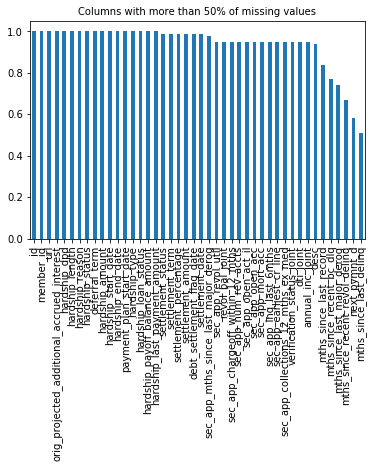

In [ ]:
#columns with more than 50% of missing values
null[null>=0.5].plot(kind='bar')
plt.title('Columns with more than 50% of missing values',fontsize=10)
plt.show

In [ ]:
#dropping columns with 50% of missing values
loan.drop(null[null>=0.5].index, axis=1, inplace=True) 
loan.shape

(2260668, 101)

In [ ]:
#again,checking structure of missing valuse
null = loan.isnull().sum().sort_values(ascending=False)/float(len(loan))
null

il_util               0.472803
mths_since_rcnt_il    0.402502
all_util              0.383227
inq_last_12m          0.383130
open_acc_6m           0.383130
                        ...   
total_pymnt_inv       0.000000
total_pymnt           0.000000
out_prncp_inv         0.000000
out_prncp             0.000000
loan_amnt             0.000000
Length: 101, dtype: float64

<function matplotlib.pyplot.show>

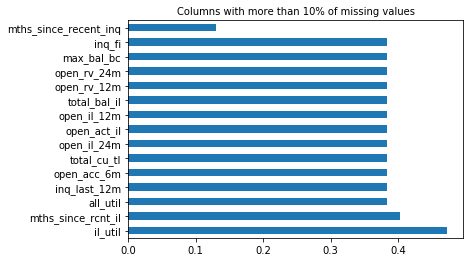

In [ ]:
#columns which have more than 10% of missing values
null[null>=0.1].plot('barh')
plt.title('Columns with more than 10% of missing values',fontsize=10)
plt.show

In [ ]:
#dropping columns with more than 10% of missing values
loan.drop(null[null>=0.10].index, axis=1, inplace=True) 
loan.shape

(2260668, 86)

###c) dependent variable structure

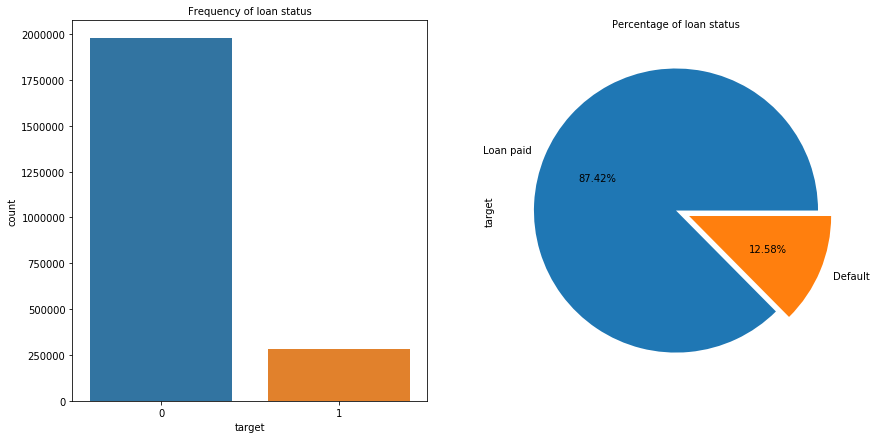

In [ ]:
#checking dependent variable structure
fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='target',data=loan,ax=axs[0])
axs[0].set_title("Frequency of loan status", fontsize=10)
loan.target.value_counts().plot(x=None,y=None,kind='pie',labels=['Loan paid', 'Default'],explode=(0,0.1), ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of loan status", fontsize=10)
plt.show()

As we can see, the dataset is unbalanced. There are much more people paying the loan.

###d) data types structure

<function matplotlib.pyplot.show>

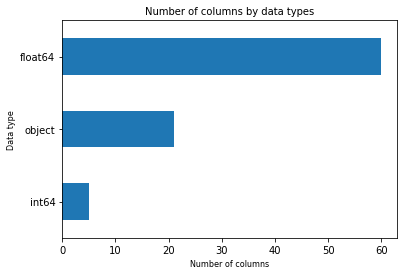

In [ ]:
loan.dtypes.value_counts().sort_values().plot(kind='barh')
plt.title('Number of columns by data types',fontsize=10)
plt.xlabel('Number of columns',fontsize=8)
plt.ylabel('Data type',fontsize=8)
plt.show

The dataset contains quite a big number of categorcial columns

###e) checking categorical columns

In [ ]:
#number of categories in each column
loan.select_dtypes('object').apply(pd.Series.nunique, axis = 0).sort_values(ascending=False)

emp_title               512694
title                    63155
zip_code                   956
earliest_cr_line           754
last_credit_pull_d         140
issue_d                    139
last_pymnt_d               135
addr_state                  51
sub_grade                   35
purpose                     14
emp_length                  11
grade                        7
home_ownership               6
verification_status          3
debt_settlement_flag         2
pymnt_plan                   2
disbursement_method          2
initial_list_status          2
application_type             2
hardship_flag                2
term                         2
dtype: int64

In [ ]:
#dropping columns with many categories and coulmns with useless information
useless = ['funded_amnt', 'funded_amnt_inv','issue_d','sub_grade','int_rate','emp_title',
         'zip_code','earliest_cr_line','last_pymnt_d','last_credit_pull_d','title','addr_state']
loan=loan.drop(useless, axis = 1)
loan.shape

(2260668, 89)

We decided to drope some columns because they leak information from the future or they require a lot of pre-processing to be useful for the model.

In [ ]:
#these categorical coulumns could be changed into numeric columns
print(loan['emp_length'].value_counts())
print(loan['grade'].value_counts())

10+ years    748005
2 years      203677
< 1 year     189988
3 years      180753
1 year       148403
5 years      139698
4 years      136605
6 years      102628
7 years       92695
8 years       91914
9 years       79395
Name: emp_length, dtype: int64
B    663557
C    650053
A    433027
D    324424
E    135639
F     41800
G     12168
Name: grade, dtype: int64


In [ ]:
#mappings
transformation = {
"emp_length": {
"10+ years": 10,
"9 years": 9,
"8 years": 8,
"7 years": 7,
"6 years": 6,
"5 years": 5,
"4 years": 4,
"3 years": 3,
"2 years": 2,
"1 year": 1,
"< 1 year": 0,
},
"grade":{
"A": 1,
"B": 2,
"C": 3,
"D": 4,
"E": 5,
"F": 6,
"G": 7
}
}
loan = loan.replace(transformation)
loan.head()

,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,target
0,2500,36 months,84.92,3,10.0,RENT,55000.0,Not Verified,n,debt_consolidation,18.24,0.0,1.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,84.92,0.0,1,Individual,0.0,0.0,16901.0,42000.0,9.0,1878.0,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N,0
1,30000,60 months,777.23,4,10.0,MORTGAGE,90000.0,Source Verified,n,debt_consolidation,26.52,0.0,0.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,777.23,0.0,1,Individual,0.0,1208.0,321915.0,50800.0,10.0,24763.0,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N,0
2,5000,36 months,180.69,4,6.0,MORTGAGE,59280.0,Source Verified,n,debt_consolidation,10.51,0.0,0.0,8.0,0.0,4599,19.1,13.0,w,4787.21,4787.21,353.89,353.89,212.79,141.10,0.0,0.0,0.0,180.69,0.0,1,Individual,0.0,0.0,110299.0,24100.0,4.0,18383.0,13800.0,0.0,0.0,0.0,87.0,92.0,15.0,14.0,2.0,77.0,0.0,0.0,3.0,3.0,3.0,4.0,6.0,7.0,3.0,8.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N,0
3,4000,36 months,146.51,4,10.0,MORTGAGE,92000.0,Source Verified,n,debt_consolidation,16.74,0.0,0.0,10.0,0.0,5468,78.1,13.0,w,3831.93,3831.93,286.71,286.71,168.07,118.64,0.0,0.0,0.0,146.51,0.0,1,Individual,0.0,686.0,305049.0,7000.0,5.0,30505.0,1239.0,75.2,0.0,0.0,62.0,154.0,64.0,5.0,3.0,64.0,0.0,1.0,2.0,1.0,2.0,7.0,2.0,3.0,2.0,10.0,0.0,0.0,0.0,3.0,100.0,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,N,0
4,30000,60 months,731.78,3,10.0,MORTGAGE,57250.0,Not Verified,n,debt_consolidation,26.35,0.0,0.0,12.0,0.0,829,3.6,26.0,w,29339.02,29339.02,1423.21,1423.21,660.98,762.23,0.0,0.0,0.0,731.78,0.0,1,Individual,0.0,0.0,116007.0,23100.0,9.0,9667.0,8471.0,8.9,0.0,0.0,53.0,216.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,3.0,8.0,9.0,6.0,15.0,2.0,12.0,0.0,0.0,0.0,5.0,92.3,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,N,0


In [ ]:
#checking a number of categories 
loan.select_dtypes('object').apply(pd.Series.nunique, axis = 0).sort_values(ascending=False)

purpose                 14
home_ownership           6
verification_status      3
debt_settlement_flag     2
disbursement_method      2
hardship_flag            2
application_type         2
initial_list_status      2
pymnt_plan               2
term                     2
dtype: int64

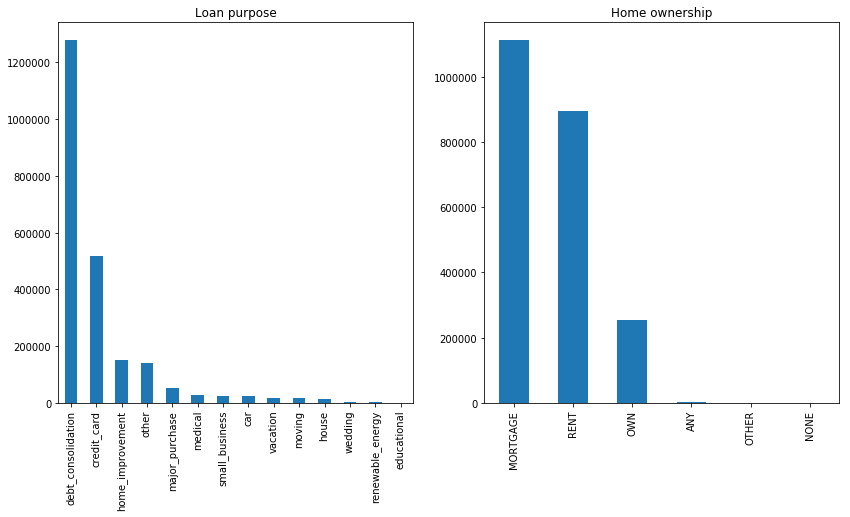

In [ ]:
#checking categories in 'purpose' and 'home ownership' column
fig, axs = plt.subplots(1,2,figsize=(14,7))
loan['purpose'].value_counts().plot(kind='bar',ax=axs[0])
axs[0].set_title("Loan purpose")
loan['home_ownership'].value_counts().plot(kind='bar',ax=axs[1])
axs[1].set_title("Home ownership")
plt.show()

In [ ]:
#reducing number of categories in home_ownership column
loan['home_ownership']=loan['home_ownership'].replace(['ANY', 'NONE'], 'OTHER')
loan['home_ownership'].value_counts()

MORTGAGE    1111450
RENT         894929
OWN          253057
OTHER          1232
Name: home_ownership, dtype: int64

In [ ]:
#reducing number of categories in purpose column
col = ['major_purchase','medical','small_business','car', 'vacation','moving','house','wedding', 'renewable_energy', 'educational']
loan['purpose']=loan['purpose'].replace(col, 'Special')
loan['purpose'].value_counts()

debt_consolidation    1277877
credit_card            516971
Special                175923
home_improvement       150457
other                  139440
Name: purpose, dtype: int64

###f) numerical columns

In [ ]:
#changing dictionary column names
dictionary = dictionary.rename(columns={'LoanStatNew': 'Name', 'Description': 'Description'})

In [ ]:
#joining two datasets (loans and dictionary)
loans_dtypes = pd.DataFrame(loan.dtypes,columns=['Dtypes'])
loans_dtypes = loans_dtypes.reset_index()
loans_dtypes['Name'] = loans_dtypes['index']
loans_dtypes = loans_dtypes[['Name','Dtypes']]
loans_dtypes['First value'] = loan.loc[0].values
preview = loans_dtypes.merge(dictionary, on='Name',how='left')

In [ ]:
#pandas settings to see whole 'description'column
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)  

In [ ]:
#checking numeric columns
preview[(preview.values  == "float64")|(preview.values  == "int64" )]

,Name,Dtypes,First value,Description
0,loan_amnt,int64,2500,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
2,installment,float64,84.92,The monthly payment owed by the borrower if the loan originates.
3,grade,int64,3,LC assigned loan grade
4,emp_length,float64,10,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
6,annual_inc,float64,55000,The self-reported annual income provided by the borrower during registration.
10,dti,float64,18.24,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
11,delinq_2yrs,float64,0,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
12,inq_last_6mths,float64,1,The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
13,open_acc,float64,9,The number of open credit lines in the borrower's credit file.
14,pub_rec,float64,1,Number of derogatory public records


In [ ]:
#dropping columns with useless information
useless_2 = ['out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
           'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries',
            'collection_recovery_fee','last_pymnt_amnt']
loan=loan.drop(useless_2, axis = 1)
loan.shape

(2260668, 64)

Again, we decided to drop some columns because they contain redundant information.

###g) noise cleaning

In [ ]:
#dropping columns with only one value
loan = loan.loc[:,loan.apply(pd.Series.nunique) != 1]
loan.shape

(2260668, 63)

In [ ]:
def getDuplicateColumns(df):
    
    duplicateColumnNames = set()
    for x in range(df.shape[1]):
        col = df.iloc[:, x]
        for y in range(x + 1, df.shape[1]):
            otherCol = df.iloc[:, y]
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
 
    return list(duplicateColumnNames)

In [ ]:
#checking duplicated columns
getDuplicateColumns(loan)

[]

The dataset doesn't contain duplicated columns.

In [ ]:
#checking duplicated rows
loan.duplicated(subset=None, keep='first')
loan.shape

(2260668, 63)

Lack of duplicated columns and rows

#Pre-processing

In [ ]:
#splitting the dataset
X=loan.drop(['target'],axis=1)
y=loan['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123)

In [ ]:
#chosing columns for pre-procesingu
categorical = list(X_train.select_dtypes('object').columns)
numeric = list(X_train.select_dtypes(['float64','int64']).columns)

In [ ]:
#preparing pipeline for pre-processing

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(numeric)),
        ("imputer", SimpleImputer(strategy="median")),
      
    ])

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)
    

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(categorical)),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

#Models creation

Because of we're dealing with binary classification problem and also we have unbalanced dataset, we decided to check three algorithms:


*   Logistic regression
*   Random forest
*   XGBoost







##a) Logistic Regression

In [ ]:
pipe_1 = Pipeline([('preprocessing', preprocess_pipeline),('classifier', LogisticRegression(penalty='l1', class_weight= {0: 0.15, 1: 0.85}, C=0.1, random_state=42))])

pipe_1.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('num_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('select_numeric',
                                                                  DataFrameSelector(attribute_names=['loan_amnt',
                                                                                                     'installment',
                                                                                                     'grade',
                                                                                                     'emp_length',
                                                                                                     'annual_inc',
                                                                                                     'dti',
   

##b) Random Forest

In [ ]:
pipe_2 = Pipeline([('preprocessing', preprocess_pipeline),('classifier', RandomForestClassifier(bootstrap=True,n_estimators=1000,class_weight={0: 1, 1: 6},min_samples_leaf=500,max_features='sqrt',n_jobs=-1,oob_score=True,random_state = 42,max_depth=10))])

pipe_2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('num_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('select_numeric',
                                                                  DataFrameSelector(attribute_names=['loan_amnt',
                                                                                                     'installment',
                                                                                                     'grade',
                                                                                                     'emp_length',
                                                                                                     'annual_inc',
                                                                                                     'dti',
   

##c) XGBoost

In [ ]:
#setting scale_pos_weight due to unbalanced dataset
scale_pos_weight=y_train[y_train==0].count()/y_train[y_train==1].count()

In [ ]:
pipe_3 = Pipeline([('preprocessing', preprocess_pipeline),('classifier', XGBClassifier(learning_rate =0.1, n_estimators=1000,
                                                                                                                     gamma=0,
                                                                                                                     max_depht=10,
                                                                                                                     min_child_weight=5,
                                                                                                                     subsample=0.8,
                                                                                                                     colsample_bytree=0.8,
                                                                                                                     eval_metrics="roc_auc",
                                                                                                                     scale_pos_weight=scale_pos_weight,
                                                                                                                     n_thread=4, seed=42, cv=5, max_delta_step=3,
                                                                                                                     objective= 'binary:logistic'))])

pipe_3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('num_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('select_numeric',
                                                                  DataFrameSelector(attribute_names=['loan_amnt',
                                                                                                     'installment',
                                                                                                     'grade',
                                                                                                     'emp_length',
                                                                                                     'annual_inc',
                                                                                                     'dti',
   

#Model selection

The model selection will be conducted using ROC curve and classification metrics as AUC, F1, precision and recall which was calculated on test set.

###a) ROC curve

In [ ]:
# roc function
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.1, 1.1, -0.1, 1.1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

In [ ]:
#calculating probability
y_scores_1 = pipe_1.decision_function(X_test)

predictions_rt = pipe_2.predict_proba(X_test)
y_scores_2=predictions_rt[:,1]

predictions_xg = pipe_3.predict_proba(X_test)
y_scores_3=predictions_xg[:,1]

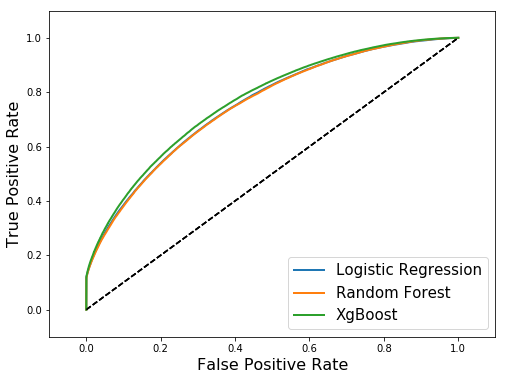

In [ ]:
#plotting roc curve
fpr_clf_1, tpr_clf_1, thresholds_clf_1 = roc_curve(y_test, y_scores_1)
fpr_clf_2, tpr_clf_2, thresholds_clf_2 = roc_curve(y_test, y_scores_2)
fpr_clf_3, tpr_clf_3, thresholds_clf_3 = roc_curve(y_test, y_scores_3)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_clf_1, tpr_clf_1, "Logistic Regression")
plot_roc_curve(fpr_clf_2, tpr_clf_2, "Random Forest")
plot_roc_curve(fpr_clf_3, tpr_clf_3, "XgBoost")
plt.legend(loc="lower right", fontsize=15)
plt.show()

###b) Classification metrics

In [ ]:
models = []
models.append(('LR', pipe_1))
models.append(('Random Forest', pipe_2))
models.append(('XgBoost', pipe_3))

precision_score = []
recall_score = []
f1_score = []
auc_score = []
for name, model in models:
    precision_score.append(metrics.precision_score(y_test , model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test , model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test , model.predict(X_test)))
    auc_score.append(metrics.roc_auc_score(y_test , model.predict(X_test)))

In [ ]:
#creating a table with outcomes
mapping = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'auc_score' : auc_score
    }
outcomes_table = pd.DataFrame(data=mapping)
outcomes_table.insert(loc=0, column='Method', value=['Logistic Regression','Random Forest','XGBoost'])
outcomes_table

,Method,precision_score,recall_score,f1_score,auc_score
0,Logistic Regression,0.275034,0.552442,0.367238,0.671049
1,Random Forest,0.262157,0.585946,0.362244,0.673865
2,XGBoost,0.247435,0.677570,0.362494,0.689945
